In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
!git clone https://github.com/Amey-2002/GSoC_2022_QMLHEP

Cloning into 'GSoC_2022_QMLHEP'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 223 (delta 4), reused 8 (delta 3), pack-reused 212
Receiving objects: 100% (223/223), 1.76 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [2]:
# To remove the cloned repo from the folders section, uncomment the following command

# !rm -rf GSoC_2022_QMLHEP

In [4]:
%cd /content/GSoC_2022_QMLHEP/

/content/GSoC_2022_QMLHEP


In [5]:
from IPython.display import clear_output
!pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver
clear_output()

### Getting the imports

In [8]:
import numpy as np
import tensorflow as tf
from h5py import File as HDF5File
import QGANSHEP
from QGANSHEP.Quantum_Conv2D_layer import QConv2D_layer
from QGANSHEP import preprocess_utils, frechet_inception_distance, visualizations
%matplotlib inline
import matplotlib.pyplot as plt

## Fetching and Preprocessing the dataset

In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
electron_data.keys()

<KeysViewHDF5 ['X', 'y']>

In [ ]:
X_electron = electron_data['X']

In [ ]:
X_electron.shape

(249000, 32, 32, 2)

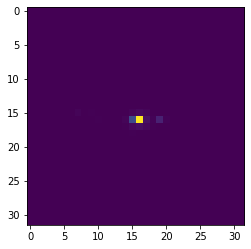

In [ ]:
#Let's have a look on one of the images
plt.imshow(X_electron[0,:,:,0])

In [ ]:
X_electron = electron_data['X'][:,:,:,0]

In [ ]:
X_electron.shape

(249000, 32, 32)

In [ ]:
#preprocess the images(here: crop the images)X_electron = preprocess_utils.crop_images(X_electron,(8,8))
X_electron = X_electron[:300]

In [ ]:
#vanity check
X_electron.shape

(300, 32, 32)

In [ ]:
X_electron = preprocess_utils.crop_images(X_electron,(8,8))

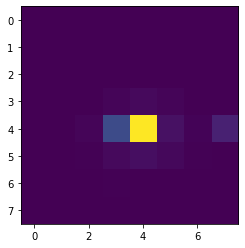

In [ ]:
#Let's have a look at the image after cropping it.
plt.imshow(X_electron[0])

### Generator

In [ ]:
def create_generator():
  model = tf.keras.Sequential(name = 'Generator')
  model.add(tf.keras.layers.Input(shape=(64), dtype=tf.float32))
  model.add(tf.keras.layers.Reshape((8, 8, 1)))
  model.add(QConv2D_layer(circuit_layers=1, filter_shape=(3, 3),conv_id ='1',
                      filters=2, stride=(1, 1), padding="same", parameter_sharing=False,seed=2021,
                      ))
  model.add(QConv2D_layer(circuit_layers=2, filter_shape=(2, 2),conv_id = '2',
                      filters=1, stride=(1, 1), padding="same", parameter_sharing=True,seed=2022,
                      ))
  return model

In [ ]:
generator_model = create_generator()

###Discriminator

In [ ]:
def create_discriminator():
  model = tf.keras.Sequential(name = 'Discriminator_Improved')
  model.add(tf.keras.Input(shape=(8, 8, 1),dtype=tf.dtypes.float32,name='Input_layer'))
  model.add(QConv2D_layer(circuit_layers=2, filter_shape=(3, 3),conv_id ='1',
                      filters=2, stride=(2, 2), padding="same", parameter_sharing=False,seed=2021,
                      ))
  model.add(QConv2D_layer(circuit_layers=2, filter_shape=(2, 2),conv_id = '2',
                      filters=1, stride=(2, 2), padding="same", parameter_sharing=False,seed=2022,
                      ))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  return model

In [ ]:
discriminator_model = create_discriminator()

In [ ]:
generator_model.summary()
discriminator_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 8, 8, 1)           0         
                                                                 
 Quantum_Convolutional_Layer  (None, 8, 8, 2)          3456      
 _with_padding1 (QConv2D_lay                                     
 er)                                                             
                                                                 
 Quantum_Convolutional_Layer  (None, 8, 8, 1)          48        
 _with_padding2 (QConv2D_lay                                     
 er)                                                             
                                                                 
Total params: 3,504
Trainable params: 3,504
Non-trainable params: 0
_________________________________________________________________
Model: "Discriminator_Improved"
_______________________

###QGAN Model

In [ ]:
# setting the optimizer for the generator and discriminator along with the learning rate 
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# initiating the model
model = QGANS.QGAN(generator=generator_model,discriminator=discriminator_model,disc_optimizer=d_optimizer,gen_optimizer=g_optimizer)

###Model Training

In [ ]:
X_electron_final = np.reshape(X_electron, (X_electron.shape[0], 8, 8, 1))
gen_loss, disc_loss ,epochs = model.train_qgans(X_electron,epochs=20,batch_size=70,seed=2021,n_gen=5)

Epoch:0 ;   generator_loss:-0.6573505401611328 ;   discriminator_loss:1.3873404264450073
Epoch:1 ;   generator_loss:-0.670941174030304 ;   discriminator_loss:1.3856446743011475
Epoch:2 ;   generator_loss:-0.6885965466499329 ;   discriminator_loss:1.3899610042572021
Epoch:3 ;   generator_loss:-0.7010630965232849 ;   discriminator_loss:1.3921771049499512
Epoch:4 ;   generator_loss:-0.7042450904846191 ;   discriminator_loss:1.38985013961792
Epoch:5 ;   generator_loss:-0.703340470790863 ;   discriminator_loss:1.3869277238845825
Epoch:6 ;   generator_loss:-0.7020527124404907 ;   discriminator_loss:1.3859989643096924
Epoch:7 ;   generator_loss:-0.69973224401474 ;   discriminator_loss:1.3856914043426514
Epoch:8 ;   generator_loss:-0.6963157057762146 ;   discriminator_loss:1.3854163885116577
Epoch:9 ;   generator_loss:-0.6930720210075378 ;   discriminator_loss:1.38528311252594
Epoch:10 ;   generator_loss:-0.6906778216362 ;   discriminator_loss:1.3851394653320312
Epoch:11 ;   generator_loss:-0.

###Plotting the loss

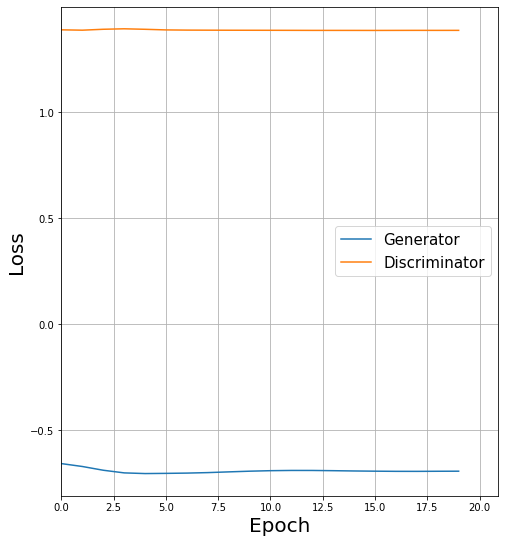

In [ ]:
model.plot_loss(gen_loss,disc_loss,epochs)

###Creating images

Generating random data...
Fetching images from generator...
Generated Images:


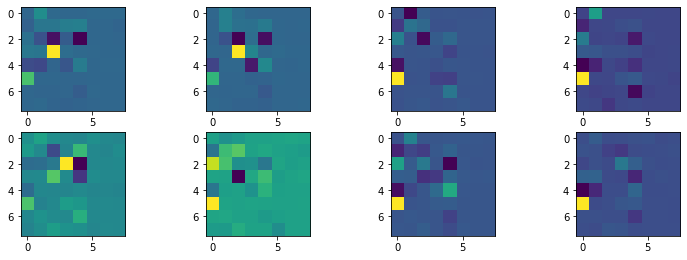

In [ ]:
samples = model.create_images(batch_size=100)

In [ ]:
fid = frechet_inception_distance.FID()
print(f'Frechet Inception Distance for the generated images is: {fid.calculate(X_electron[:100],samples)}')

Frechet Inception Distance for the generated images is: 2.4635494044649264
